# **Additional downloads**

In [ ]:
%%capture
import os
# Deep networks: addtionally downloads
! git clone https://github.com/philipperemy/keras-attention-mechanism.git 
os.chdir('/content/keras-attention-mechanism')
from attention import Attention
# process tracker
! pip install -q "tqdm>=4.36.1"
# Ensemble methods: additional downloads
! pip install catboost
! pip install lightGBM
! pip install -Iv xgboost==1.0.0
# Optimization packages 
! pip install bayesian-optimization
! pip install scipy==1.4.1

# **Imports**

In [ ]:
import os
import sys
import gc
# data handling, storing and core modules 
import h5py
import pickle
import datetime
import scipy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
# colab configuration modules
import warnings
from google.colab import drive  
from IPython.display import display
# Plotting modules
from matplotlib import rc
from matplotlib import style 
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
style.use('seaborn-bright')
plt.rcParams['font.family'] = "serif"
import seaborn as sns
# preprocessing modules
import tensorflow as tf
from tensorflow.sparse import SparseTensor
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Architectural modules
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, TimeDistributed, Flatten, Average
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, Embedding, Bidirectional, Input, Conv1D, Reshape
from tensorflow.keras.backend import concatenate

# training modules
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
# Evaluation modules 
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix
# Optimization modules 
from bayes_opt import BayesianOptimization
from scipy.optimize import dual_annealing
# Ensemble methods 
import xgboost as xgb
from xgboost import XGBClassifier 
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost as cgb
from catboost import CatBoostClassifier

drive.mount('/content/gdrive')
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

os.chdir('/content/gdrive/My Drive/Colab Notebooks/phone_user_reviews/nlp_scripts/data')
df = pickle.load(open('df_ENGLISH_ONLY.pickle','rb'))
df = df.dropna(axis=0)
df.drop(columns=['date', 'product', 'lang'], inplace=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Data: Loading & saving**

In [ ]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/phone_user_reviews/nlp_scripts/data')
df = pickle.load(open('df_ENGLISH_ONLY.pickle','rb'))
df = df.dropna(axis=0)
df.drop(columns=['date', 'product', 'lang'], inplace=True)

def origin_country_data_aggregating(df):
  '''Function generates dictionary of grouped country data'''
  country_group = df.groupby(['country'])
  os.chdir('/content/gdrive/My Drive/Colab Notebooks/phone_user_reviews/nlp_scripts/data')
  abb_2_country_name = pickle.load(open('language_abbreviation_dictionary.pickle', 'rb'))
  countries_abb = tuple(set(df.country.values))
  country_wise_df = {abb_2_country_name[abb]: country_group.get_group(abb) for abb in countries_abb}
  print(f'========== Partioning dataset via countries ==========\n\n Number of countries: {len(countries_abb)}\n')
  for country in country_wise_df.keys(): 
    print(f'{country}\nNo. of examples: {country_wise_df[country].shape[0]}\n\n')
  return country_wise_df

c_w_df = origin_country_data_aggregating(df)
# Note only ['United States', 'India', 'Great Britain'] have sufficient examples to extract structural information

def gradient_boosting_model_saving(clf, architecture, model_name, country):
  '''Saves trained model in fitted model directory.'''
  os.chdir('/content/gdrive/My Drive/Colab Notebooks/phone_user_reviews/nlp_scripts/fitted_models')
  try: 
    os.mkdir(architecture)
  except FileExistsError:
    os.chdir('/content/gdrive/My Drive/Colab Notebooks/phone_user_reviews/nlp_scripts/fitted_models' + f'/{architecture}')
    pass
  model_name = model_name.replace(':', '_')
  model_name = model_name.replace(' ', '_')
  with open(f'{model_name}.pickle.dat', 'wb') as file_handle:
    pickle.dump(clf, file_handle )

################################################################################

def gradient_boosting_model_loading(model_name, country, architecture):
  '''Loading trained ensemble'''
  os.chdir('/content/gdrive/My Drive/Colab Notebooks/phone_user_reviews/nlp_scripts/fitted_models' + f'/{architecture}')
  model_name = model_name.replace(':', '_')
  model_name = model_name.replace(' ', '_')
  return pickle.load(open(f'{model_name}.pickle.dat', 'rb'))

################################################################################

COUNTRY = ['Great Britain', 'United States', 'India']

========== Partioning dataset via countries ==========

 Number of countries: 8

Great Britain
No. of examples: 93351


India
No. of examples: 127873


United States
No. of examples: 312110


South Africa
No. of examples: 25


Singapore
No. of examples: 10


New Zealand
No. of examples: 71


Australia
No. of examples: 866


Canada
No. of examples: 11118




# **Evaluation: Training & performance evaluation functions**

In [ ]:
def learning_curve_plotting(model_name, History):
  '''Plotting learning routine: History object returned by model fitting function
  ------> tensorflow'''
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
  x1, y1 = np.arange(1, NO_EPOCHS+1, 1), History['loss']
  x2, y2 = np.arange(1, NO_EPOCHS+1, 1), History['val_loss']
  x3, y3 = np.arange(1, NO_EPOCHS+1, 1), History['accuracy']
  x4, y4 = np.arange(1, NO_EPOCHS+1, 1), History['val_accuracy']
  x5, y5 = np.arange(0, NO_EPOCHS,1), History['lr']
  handle1 = ax1.plot( x1, y1,'o-', color='blue',  label="Validation loss")
  handle2 = ax1.plot( x2, y2 ,'o-',color='coral',  label="Training loss")
  ax1.set_title(f'{model_name}\n learning curves: Loss', size='18')
  ax1.set_xlabel('Epochs', size='16')
  ax1.set_ylabel('Loss', size='16')
  ax1.legend(loc="best" )
  handle3 = ax2.plot(x3, y3, 'o-', color='blue', label="Validation accuracy")
  handle4 = ax2.plot(x4, y4, 'o-', color='coral', label='Training accuracy')
  ax2.set_title(f'{model_name}\n accuracy', size='18')
  ax2.set_xlabel('Epochs', size='16')
  ax2.set_ylabel('Accuracy', size='16')
  ax2.legend(loc="best")
  # Learning rate plotting
  ax3.set_title(f'Learning rate scheduling', size='18')
  handle5 = ax3.plot(x5, y5,'o-', color='blue',  label="Learning rate")
  ax3.set_xlabel('Epochs', size='16')
  ax3.set_ylabel('Learning rate', size='16')
  ax3.set_ylim([-0.0001,0.0012])
  ax3.legend(loc="best")

################################################################################

def evaluation_report(clf, X_data, Y_true, model_name, tensorflow=False):
  '''Function produces classification report'''

  if tensorflow == True:     
    Y_predict = [ p for p in clf.predict_on_batch(X_data).argmax(axis=-1)]
    Y_t = [ p for p  in tf.argmax(Y_true, axis=1).numpy().tolist()]

  if tensorflow == False: 
    Y_predict = clf.predict(X_data) # .argmax(axis=-1)]
    Y_t = Y_true.to_numpy().argmax(axis=1).tolist()

  sample_weights = compute_sample_weight(class_weight='balanced', y=Y_t)
  class_report = classification_report(y_true=Y_t, y_pred=Y_predict,
                                       target_names=['Negative','Neutral','Positive'])
  print(f'Classification report\n{class_report}:\n')

################################################################################

def confusion_matrix_plotting(clf, X_data, Y_true, model_name, routine, tensorflow=False):
  '''Function plots the confusion matrix'''
  if tensorflow == True: 
    Y_predict = [ p for p in clf.predict_on_batch(X_data).argmax(axis=-1)]
    Y_t = [ p for p  in tf.argmax(Y_true, axis=1).numpy().tolist()]
  
  if tensorflow == False: 
    Y_predict = clf.predict(X_data) # .argmax(axis=-1)
    Y_t = Y_true.to_numpy().argmax(axis=1).tolist()


  cf_matrix = confusion_matrix(Y_t, Y_predict)
  fig = plt.figure(figsize=(7,7))
  ax1 = fig.add_subplot(111)
  ax1.set_title(f'{model_name}\n{routine} confusion matrix', size=18)
  sns.heatmap(cf_matrix, annot=True, ax=ax1, annot_kws={'fontsize':18},fmt='.0f',
              cmap='Blues', cbar=False)
  ax1.set_xticklabels(['Negative', 'Neutral', 'Positive'],size=14)
  ax1.set_xlabel('Truth', size=16)
  ax1.set_yticklabels(['Negative', 'Neutral','Positive'],size=14)
  ax1.set_ylabel('Predicted',size=16)

################################################################################

def multiclass_ROC_plotting(tensorflow, clf, Y_true, X_data, model_name): 
  '''Plots multi-class ROC and AUC statistics. Expecting variables to be: 
    Y_true:                     array of 1 hot encoded classes 
    Y_predicted_probabilities:  array of corresponding probabilities
    model_name:                 architecture name as string'''
  fpr, tpr, roc_auc = dict(), dict(), dict()
  sentiment = ('Negative', 'Neutral', 'Postive')
  class_no = (0, 1, 2)
  class_to_sent = dict(zip(class_no, sentiment))

  if tensorflow == True: 
    Y_predict = np.asarray(clf.predict_on_batch(X_data).tolist())
    Y_true = np.asarray(Y_true)
    
  if tensorflow == False: 
    Y_predict = clf.predict_proba(X_data)
    Y_true = np.asarray(Y_true) ###################################################################################################

  for i in range(len(class_no)):
      fpr[i], tpr[i], _ = roc_curve(Y_true[:, i], Y_predict[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(Y_true.ravel(), Y_predict.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  # Plot ROC curve
  plt.figure(figsize=(10,10))
  plt.step(fpr["micro"], tpr["micro"],
          label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')
  
  for i in range(len(class_no)):
      plt.step(fpr[i], tpr[i], label=f'ROC curve of class: {class_to_sent[i]} (area = {roc_auc[i]:0.2f})')

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False positive rate', size=14)
  plt.ylabel('True positive rate', size=14)
  plt.title(f' Receiver operating characteristic for multi-class sentiment\nModel: {model_name}', size=18)
  plt.legend(loc="lower right", prop={'size': 14})
  plt.show()

################################################################################

# Function produces all evaluation metrics
def model_evaluation(model, evaluation_features, evaluation_targets, model_name, history_object = None, tensorflow=False):
  '''Note input is 1h encoded targets'''
  if history_object is not None:
    learning_curve_plotting(model_name=model_name, History=history_object.history)
    
  confusion_matrix_plotting(clf=model, X_data=evaluation_features ,
                            Y_true=evaluation_targets, model_name=model_name,
                            routine='Evaluation')
  
  evaluation_report(clf=model, Y_true=evaluation_targets, X_data=evaluation_features, model_name=model_name)
  multiclass_ROC_plotting(tensorflow, clf=model, Y_true=evaluation_targets, X_data=evaluation_features, model_name=model_name)

################################################################################

def feature_importance_plotting_xgb(model, model_name, calc_type='weight'):

  fig = plt.figure(figsize=(3,8))
  ax1 = fig.add_subplot(111)
  xgb.plot_importance(booster=model, ax=ax1, height=0.2, title=f'{model_name}\nauxiliary feature importance',
                      xlabel=f'{calc_type.capitalize()}', ylabel='Features',
                      importance_type=calc_type,
                      max_num_features=15, 
                      show_values=False,
                      grid=False)
  
################################################################################

def feature_importance_plotting_lgb(model, model_name, calc_type='gain'):
  fig = plt.figure(figsize=(3,8))
  ax1 = fig.add_subplot(111)
  lgb.plot_importance(booster=model,
                      ax=ax1,
                      height=0.8,
                      title=f'{model_name}\nauxiliary feature importance',
                      xlabel=f'{calc_type.capitalize()}',
                      ylabel='Features',
                      importance_type=calc_type,
                      max_num_features=15,
                      precision = 0,
                      grid=False)

def feature_importance_plotting_cgb(model, model_name):
  model.get_feature_importance()
  pass


# **Pre-processing: Data encoding & tokenization functions**

In [ ]:
NO_MODEL_LINE = len(set(df.model_line.values.tolist()))
NO_MANUFACTURER = len(set(df.manufacturer.values.tolist())) 
NO_COUNTRY = len(set(df.country.values.tolist())) 
NO_DOMAIN = len(set(df.domain.values.tolist())) 
NO_PHONE = len(set(df.phone_url.values.tolist()))
VOCAB_SIZE = 10000
OUTPUT_DIMENSION = 64
EXTRACT_MAX_LENGTH = 100 

print(f'Number of categorical realisations: \n')
print(f'Countries: {NO_COUNTRY}\nManufacturers: {NO_MANUFACTURER}\nModel lines:{NO_MODEL_LINE}\nDomains: {NO_DOMAIN}\nPhone: {NO_PHONE}')

def tokenization(df):
  OOV_TAG = '<oov>'
  tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!#$&()*+,-/:;=?', lower=True,
                        split=' ', oov_token=OOV_TAG)
  tokenizer.fit_on_texts(df.extract.values.tolist())
  corpus = df.extract.values.tolist()
  tokenized_corpus = tokenizer.texts_to_sequences(corpus)
  encoded_corpus = pad_sequences(tokenized_corpus, padding='post', truncating='post', maxlen=EXTRACT_MAX_LENGTH)
  return encoded_corpus.tolist()

################################################################################

def nominal_label_encoding(text_to_number=True):
  encoder_dict = defaultdict(LabelEncoder)
  forward_transform_lambda = lambda x: encoder_dict[x.name].fit_transform(x)
  inverse_transform_lambda = lambda x: encoder_dict[x.name].inverse_transform(x)
  if text_to_number == True: 
    return forward_transform_lambda
  if text_to_number == False:
    return inverse_transform_lambda

################################################################################

def one_hot_encoding(df):
  ''' Auxilliary label one-hot encoding'''
  aux_features = ['model_line', 'manufacturer', 'country', 'domain']
  encoded_df = []
  for feature in aux_features: 
    encoded_df.append( pd.get_dummies(df[f'{feature}'], prefix=f'{feature}', drop_first=True))

  # X = pd.concat( [*encoded_df, pd.get_dummies(df['score'], prefix='sentiment')], axis=1)
  X = pd.concat( [*encoded_df], axis=1)
  return X

################################################################################

def df_to_tensor_helper(dataframe, feature):
  return tf.convert_to_tensor( np.asarray(dataframe[f'{feature}'].values.tolist()), dtype=tf.float32, name=f'{feature}')

################################################################################

def dataframe_to_tensors(df):
  tensor_features, tensor_labels = [], []
  feat_names, label_names = list(df.columns)[:-3], list(df.columns)[-3:]
  print(f'labels   : {label_names}')
  print(f'Features : {feat_names}')
  for label in tqdm(label_names, desc='Converting labels into tensors...'):
    print(f'Converting label: {label}')
    tensor_labels.append(df_to_tensor_helper(df, label))
  for feature in tqdm(feat_names, desc='Converting features into tensors...'):
    print(f'Converting feature: {feature}')
    tensor_features.append(df_to_tensor_helper(df, feature))
  axis=1
  X = tuple(tensor_features)
  Y = tf.concat([tf.expand_dims(t, axis) for t in tensor_labels], axis)
  return X,Y  


################################################################################


def dataset_splitting(df, tensorflow=True, One_hot=False):
  if tensorflow == True:
    # perform tokenization for tensorflow dataset 
    df['tokens'] = tokenization(df)
    df_encoded = pd.concat([df[['phone_url','country','domain','manufacturer','model_line']].apply(nominal_label_encoding()),
                    df[['tokens']],pd.get_dummies(df['score'], prefix='sentiment')], axis=1)
    df_train, df_eval = train_test_split(df_encoded, test_size=0.10)
    df_train, df_val = train_test_split(df_train, test_size=0.20)
    print(f'Eval set ========: {df_eval.shape[0]*100/df_encoded.shape[0]:.2f}%')
    print(f'Val set =========: {df_val.shape[0]*100/df_encoded.shape[0]:.2f}%')
    print(f'Train set =======: {df_train.shape[0]*100/df_encoded.shape[0]:.2f}%')
    Xt, Yt = dataframe_to_tensors(df_train)
    Xv, Yv = dataframe_to_tensors(df_val)
    Xe, Ye = dataframe_to_tensors(df_eval)
    return Xt, Yt, Xv, Yv, Xe, Ye

  if tensorflow == False:
    columns = list(df.columns.values)
    columns.remove('score')

    if One_hot == True:
      df_encoded = one_hot_encoding(df[columns])
    else:
      df_encoded = df[columns].apply(nominal_label_encoding())
      
    df_score = df.score.apply(lambda x: x+1)
    df_train, df_eval = train_test_split(pd.concat([df_encoded, df_score ], axis=1), test_size=0.10)
    df_train, df_val = train_test_split(df_train, test_size=0.20)

    print(f'Eval set ========: {df_eval.shape[0]*100/df_encoded.shape[0]:.2f}%')
    print(f'Val set =========: {df_val.shape[0]*100/df_encoded.shape[0]:.2f}%')
    print(f'Train set =======: {df_train.shape[0]*100/df_encoded.shape[0]:.2f}%')


    Xt, Yt = df_train[df_train.columns[:-1]], df_train[df_train.columns[-1:]]
    Xv, Yv = df_val[df_val.columns[:-1]], df_val[df_val.columns[-1:]]
    Xe, Ye = df_eval[df_eval.columns[:-1]], df_eval[df_eval.columns[-1:]]
    return Xt, Yt, Xv, Yv, Xe, Ye 

Number of categorical realisations: 

Countries: 8
Manufacturers: 147
Model lines:2458
Domains: 104
Phone: 4474


# **Model: Extreme gradient boosting: Origin country-wise analysis**

In [ ]:
FIXED_PARAMS = {
                  'objective'            : 'multi:softprob',
                  'num_class'            : 3,
                  'booster'              : 'dart',
                  'num_rounds'           : 50,
                  'learning_rate'        : 0.05,
                  'early_stopping_round' : 5,
                  'metric'               : 'merror',
                  'sample_type'          : 'uniform',
                  'gpu'                  : 0,
                  'tree_method'          : 'gpu_hist'
                }

PARAM_DOMAIN = { 
                  'gamma'                    : (0.1, 40),
                  'colsample_bytree'         : (0.1, 1),
                  'subsample'                : (0.1, 1),
                  'max_depth'                : (2, 20), 
                  'reg_alpha'                : (0.1, 20),
                  'reg_lambda'               : (0.1, 20),
                  'min_child_weight'         : (0.001, 50)
                  }

def hyper_tuning_xgb( subsample, max_depth, gamma, reg_alpha, reg_lambda, colsample_bytree,
                      min_child_weight, fixed_params = FIXED_PARAMS):
  ''' Function cross-validates extreme gradient boosting implementation '''
  params = fixed_params
  # params to optimize
  params['subsample']                  = max(min(subsample, 1), 0)
  params['colsample_bytree']           = max(min(colsample_bytree, 1), 0)
  params['max_depth']                  = int(round(max_depth))
  params['reg_alpha']                  = reg_alpha
  params['reg_lambda']                 = reg_lambda
  params['min_child_weight']           = min_child_weight

  cv_scores = xgb.cv(params = params, dtrain = data_train, nfold=5, seed=33,
                    shuffle=True, early_stopping_rounds=5, stratified=False)
  return -1.0*cv_scores['test-merror-mean'].iloc[-1]



def bayesian_ensemble_optimization( function, param_domain): 
  '''Function performs Bayesian optmization on 'black box' input function over
  parameter  domain '''
  bayesian_optimizer = BayesianOptimization(f = function,
                                            pbounds = param_domain,
                                            random_state = 3)
  bayesian_optimizer.maximize(init_points= 1,       # How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
                              n_iter = 1,           # How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
                              xi = 0.1,             # Param space Exploitation-exploration trade-off parameter 
                              acq = 'ucb',          # Param space exploration strategy; upper confidence bound
                              kappa=2.576,          # tunable parameter kappa of GP Upper Confidence Bound, to balance exploitation against exploration, increasing kappa will make the optimized hyperparameters pursuing exploration.
                              kappa_decay = 1) 
  return bayesian_optimizer

def model_evaluation_total(model_clf, architecture, paradigm, booster):
  m =  optimal_gb(X_data=Xt, Y_data =Yt, booster_type=booster , fixed_params=FIXED_PARAMS, optimizer=bayesian_optimizer)
  NAME = f"{COUNTRY[i]}: {paradigm}"
  ARCHITECT  = architecture
  feature_importance_plotting_xgb(model=model_clf, model_name=NAME)
  gradient_boosting_model_saving(clf=model_clf, country=COUNTRY[i], model_name=NAME, architecture=ARCHITECT)
  m = gradient_boosting_model_loading(model_name=NAME, country=COUNTRY[i], architecture=ARCHITECT)
  Ye_1H = pd.get_dummies(Ye.astype('category'), prefix='Sentiment')
  model_evaluation(model=m, evaluation_features=Xe, evaluation_targets=Ye_1H, model_name=NAME, history_object=None, tensorflow=False)

################################################################################

def optimal_gb(X_data, Y_data, booster_type, optimizer, fixed_params=FIXED_PARAMS):
  '''Function fits and returns optimal gradient booster'''
  optimal_params = optimizer.max['params']
  optimal_params['max_depth'] = int(optimal_params['max_depth'])
  optimal_params.update(fixed_params)

  model_booster =  booster_type(**optimal_params).fit(X = X_data, y =Y_data, sample_weight=compute_sample_weight(class_weight='balanced',y=Y_data))
  return model_booster

### **Fitting model: British review subset**

Eval set ========: 10.00%
Val set =========: 18.00%
Train set =======: 72.00%
|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.418    |  0.5957   |  28.36    |  7.236    |  25.54    |  17.87    |  17.94    |  0.213    |
|  2        | -0.4219   |  0.1513   |  36.29    |  10.18    |  41.22    |  9.081    |  3.636    |  0.6375   |
Classification report
              precision    recall  f1-score   support

    Negative       0.18      0.71      0.28      1311
     Neutral       0.52      0.34      0.41      2967
    Positive       0.71      0.29      0.41      5058

    accuracy                           0.37      9336
   macro avg       0.47      0.45      0.37      9336
weighted avg       0.57      0.37      0.39      9336
:



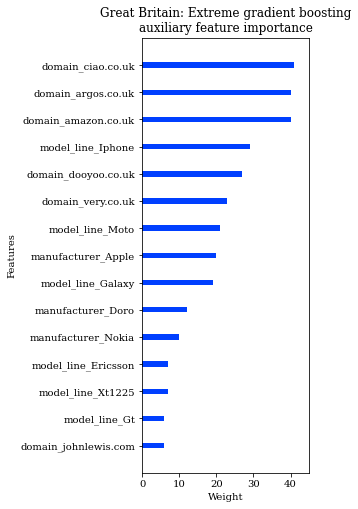

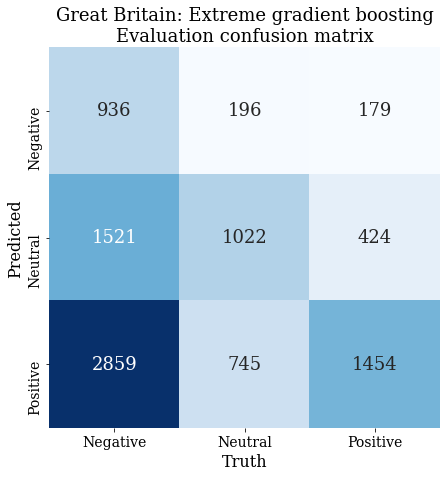

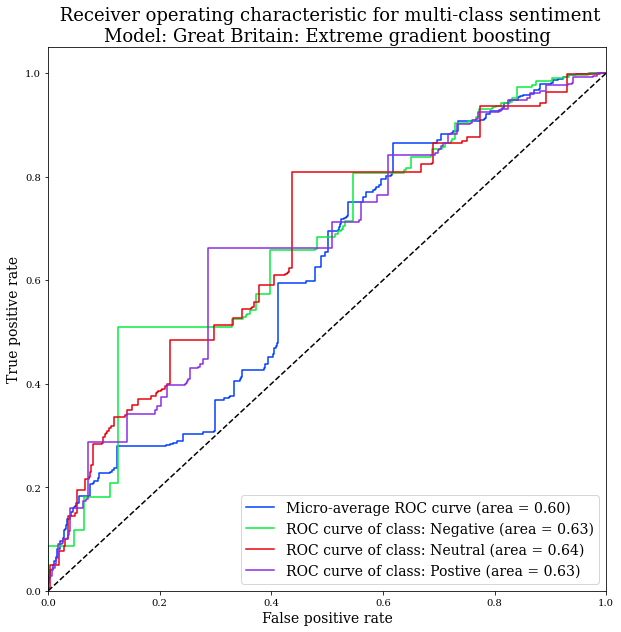

In [ ]:
i = 0
Xt,Yt, Xv, Yv, Xe, Ye = dataset_splitting(c_w_df[COUNTRY[i]], tensorflow=False, One_hot=True)
data_train = xgb.DMatrix(data=Xt,label=Yt)
data_val = xgb.DMatrix(data=Xv, label=Yv) 
data_eval = xgb.DMatrix(data=Xe, label= Ye)
################################################################################
bayesian_optimizer = bayesian_ensemble_optimization(function=hyper_tuning_xgb, param_domain=PARAM_DOMAIN)
################################################################################
model_xgb = optimal_gb(X_data=Xt, Y_data=Yt, booster_type=XGBClassifier, optimizer=bayesian_optimizer)
model_evaluation_total(model_clf=model_xgb, architecture = 'XGBoost' , paradigm = 'Extreme gradient boosting', booster_type= XGBClassifier)

### **Fitting model: American review subset**

In [ ]:
i = 1
Xt,Yt, Xv, Yv, Xe, Ye = dataset_splitting(c_w_df[COUNTRY[i]], tensorflow=False, One_hot=True)
data_train = xgb.DMatrix(data=Xt,label=Yt)
data_val = xgb.DMatrix(data=Xv, label=Yv) 
data_eval = xgb.DMatrix(data=Xe, label= Ye)
################################################################################
bayesian_optimizer = bayesian_ensemble_optimization(function=hyper_tuning_xgb, param_domain=PARAM_DOMAIN)
################################################################################
model_xgb = optimal_gb(X_data=Xt, Y_data=Yt, booster_type=XGBClassifier, optimizer=bayesian_optimizer)
model_evaluation_total(model_clf=model_xgb, architecture = 'XGBoost' , paradigm = 'Extreme gradient boosting', booster_type= XGBClassifier)

Eval set ========: 10.00%
Val set =========: 18.00%
Train set =======: 72.00%
|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------


### **Fitting model: Indian review subset**

In [ ]:
i = 2
Xt,Yt, Xv, Yv, Xe, Ye = dataset_splitting(c_w_df[COUNTRY[i]], tensorflow=False, One_hot=True)
data_train = xgb.DMatrix(data=Xt,label=Yt)
data_val = xgb.DMatrix(data=Xv, label=Yv) 
data_eval = xgb.DMatrix(data=Xe, label= Ye)
################################################################################
bayesian_optimizer = bayesian_ensemble_optimization(function=hyper_tuning_xgb, param_domain=PARAM_DOMAIN)
################################################################################
model_xgb = optimal_gb(X_data=Xt, Y_data=Yt, booster_type=XGBClassifier, optimizer=bayesian_optimizer)
model_evaluation_total(model_clf=model_xgb, architecture = 'XGBoost' , paradigm = 'Extreme gradient boosting', booster_type= XGBClassifier)

# **Model: Light gradient boosting: Origin country-wise analysis**

In [ ]:

FIXED_PARAMS = {
                'objective'           : 'multiclass',
                'num_class'           : 3,
                'boosting'            : 'gbdt',
                'num_iterations'      : 50,
                'learning_rate'       : 0.05,
                'early_stopping_round': 5,
                'metric'              : 'multi_logloss',
              }

PARAM_DOMAIN = {
                'feature_fraction'        : (0.1, 0.9),
                'subsample'               : (0.1, 1),
                'max_depth'               : (2, 20), 
                'lambda_l1'               : (0.1, 10),
                'lambda_l2'               : (0.1, 10),
                'min_gain_to_split'       : (0.001, 50),
                'num_leaves'              : (2,500)
                }

def hyper_tuning_lgb( num_leaves, feature_fraction, subsample, max_depth,
                      lambda_l1, lambda_l2, min_gain_to_split, fixed_params=FIXED_PARAMS):

  params = fixed_params
  params["num_leaves"]                 = int(round(num_leaves))
  params['feature_fraction']           = max(min(feature_fraction, 1), 0)
  params['subsample']                  = max(min(subsample, 1), 0)
  params['max_depth']                  = int(round(max_depth))
  params['lambda_l1']                  = lambda_l1
  params['lambda_l2']                  = lambda_l2
  params['min_gain_to_split']          = min_gain_to_split
  
  cv_scores = lgb.cv(params = params, train_set = data_train, nfold=5, seed=33,
                    feature_name='auto', shuffle=True, categorical_feature='auto')
  
  return -1.0*cv_scores['multi_logloss-mean'][-1]

def model_evaluation_total(model_clf, architecture, paradigm, booster):
  m =  optimal_lgb(X_data=Xt, Y_data =Yt, booster=booster , fixed_params=FIXED_PARAMS, optimizer=bayesian_optimizer)
  NAME = f"{COUNTRY[i]}: {paradigm}"
  ARCHITECT  = architecture
  feature_importance_plotting_lgb(model=model_clf, model_name=NAME)
  gradient_boosting_model_saving(clf=model_clf, country=COUNTRY[i], model_name=NAME, architecture=ARCHITECT)
  m = gradient_boosting_model_loading(model_name=NAME, country=COUNTRY[i], architecture=ARCHITECT)
  Ye_1H = pd.get_dummies(Ye.astype('category'), prefix='Sentiment')
  model_evaluation(model=m, evaluation_features=Xe, evaluation_targets=Ye_1H, model_name=NAME, history_object=None, tensorflow=False)


def optimal_lgb(X_data, Y_data, booster, optimizer, fixed_params=FIXED_PARAMS):
  '''Function fits and returns optimal gradient booster'''
  optimal_params = optimizer.max['params']
  optimal_params['num_leaves'] = int(optimal_params['num_leaves'])
  optimal_params.update(fixed_params)

  model_booster =  booster(**optimal_params).fit(X = X_data, y =Y_data, sample_weight=compute_sample_weight(class_weight='balanced',y=Y_data), eval_set=(Xe,Ye), eval_metric='multi_logloss')
  return model_booster

### **Fitting model: British review subset**

Eval set ========: 10.00%
Val set =========: 18.00%
Train set =======: 72.00%
|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | max_depth | min_ga... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.9275   |  0.5406   |  7.111    |  2.98     |  11.19    |  44.65    |  448.4    |  0.213    |
|  2        | -0.9308   |  0.1456   |  9.079    |  4.6      |  16.84    |  22.57    |  90.49    |  0.6375   |
[1]	valid_0's multi_logloss: 1.09647
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 1.09501
[3]	valid_0's multi_logloss: 1.09089
[4]	valid_0's multi_logloss: 1.09024
[5]	valid_0's multi_logloss: 1.08879
[6]	valid_0's multi_logloss: 1.08722
[7]	valid_0's multi_logloss: 1.08491
[8]	valid_0's multi_logloss: 1.08372
[9]	valid_0's multi_logloss: 1.08153
[10]	valid_0's multi_logloss: 1.08017
[11]	valid_0's multi_logloss: 1.07962
[12]	valid_0

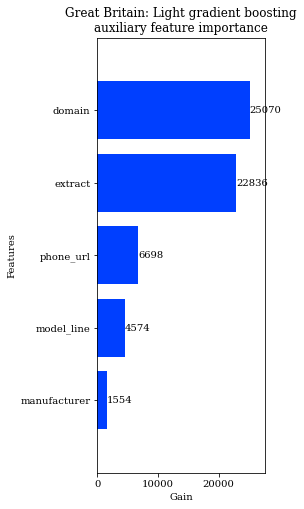

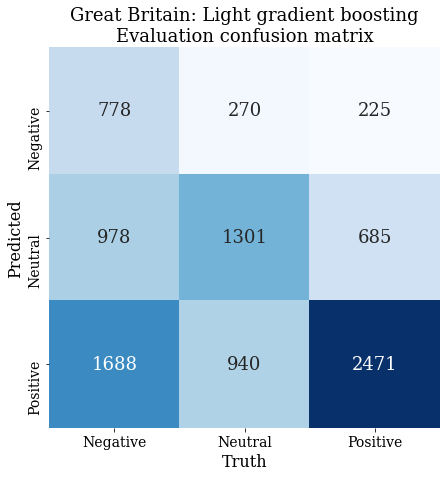

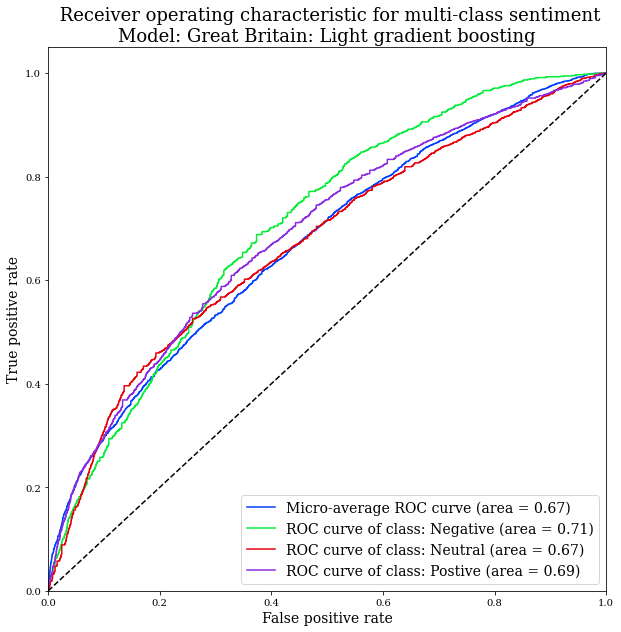

In [ ]:
i = 0
Xt,Yt, Xv, Yv, Xe, Ye = dataset_splitting(c_w_df[COUNTRY[i]], tensorflow=False, One_hot=False)
data_train = lgb.Dataset(data=Xt, label=Yt, feature_name='auto',
                        categorical_feature='auto')
data_val = lgb.Dataset(data=Xv, label=Yv, feature_name='auto',
                       categorical_feature='auto')
data_eval = lgb.Dataset(data=Xe, label=Ye)

################################################################################
bayesian_optimizer = bayesian_ensemble_optimization(function=hyper_tuning_lgb, param_domain=PARAM_DOMAIN)
################################################################################
model_lgb = optimal_lgb(X_data=Xt, Y_data=Yt, booster=LGBMClassifier, optimizer=bayesian_optimizer)
model_evaluation_total(model_clf=model_lgb, architecture = 'LGBMBoost' , paradigm = 'Light gradient boosting', booster= LGBMClassifier)

### **Fitting model: American review subset**

Eval set ========: 10.00%
Val set =========: 18.00%
Train set =======: 72.00%
|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | max_depth | min_ga... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.9619   |  0.5406   |  7.111    |  2.98     |  11.19    |  44.65    |  448.4    |  0.213    |
|  2        | -0.9752   |  0.1456   |  9.079    |  4.6      |  16.84    |  22.57    |  90.49    |  0.6375   |
[1]	valid_0's multi_logloss: 1.09551
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 1.09371
[3]	valid_0's multi_logloss: 1.08917
[4]	valid_0's multi_logloss: 1.08807
[5]	valid_0's multi_logloss: 1.0861
[6]	valid_0's multi_logloss: 1.08434
[7]	valid_0's multi_logloss: 1.08135
[8]	valid_0's multi_logloss: 1.08011
[9]	valid_0's multi_logloss: 1.07656
[10]	valid_0's multi_logloss: 1.0744
[11]	valid_0's multi_logloss: 1.07377
[12]	valid_0's

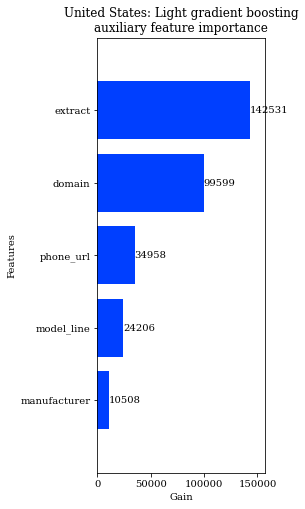

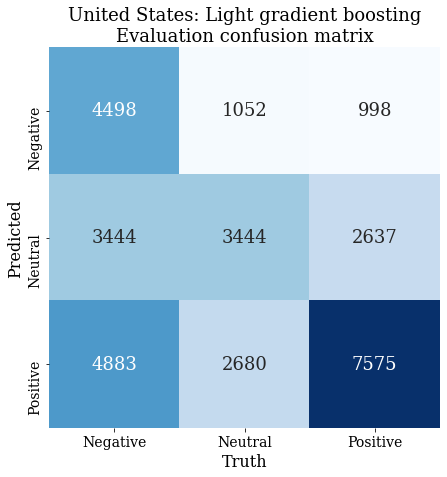

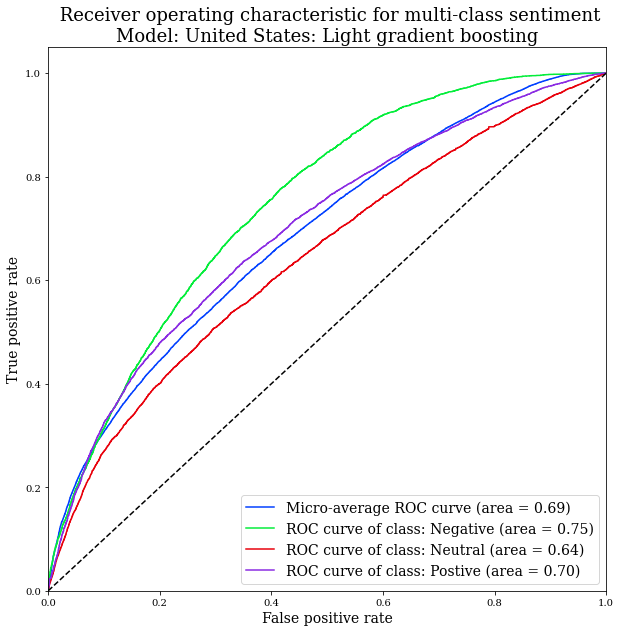

In [ ]:
i = 1
Xt,Yt, Xv, Yv, Xe, Ye = dataset_splitting(c_w_df[COUNTRY[i]], tensorflow=False, One_hot=False)
data_train = lgb.Dataset(data=Xt, label=Yt, feature_name='auto',
                        categorical_feature='auto')
data_val = lgb.Dataset(data=Xv, label=Yv, feature_name='auto',
                       categorical_feature='auto')
data_eval = lgb.Dataset(data=Xe, label=Ye)

################################################################################
bayesian_optimizer = bayesian_ensemble_optimization(function=hyper_tuning_lgb, param_domain=PARAM_DOMAIN)
################################################################################
model_lgb = optimal_lgb(X_data=Xt, Y_data=Yt, booster=LGBMClassifier, optimizer=bayesian_optimizer)
model_evaluation_total(model_clf=model_lgb, architecture = 'LGBMBoost' , paradigm = 'Light gradient boosting', booster= LGBMClassifier)


### **Fitting model: Indian review subset**

Eval set ========: 10.00%
Val set =========: 18.00%
Train set =======: 72.00%
|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | max_depth | min_ga... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.9791   |  0.5406   |  7.111    |  2.98     |  11.19    |  44.65    |  448.4    |  0.213    |
|  2        | -0.9902   |  0.1456   |  9.079    |  4.6      |  16.84    |  22.57    |  90.49    |  0.6375   |
[1]	valid_0's multi_logloss: 1.09373
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 1.09178
[3]	valid_0's multi_logloss: 1.08775
[4]	valid_0's multi_logloss: 1.08568
[5]	valid_0's multi_logloss: 1.08396
[6]	valid_0's multi_logloss: 1.08281
[7]	valid_0's multi_logloss: 1.07927
[8]	valid_0's multi_logloss: 1.07776
[9]	valid_0's multi_logloss: 1.07414
[10]	valid_0's multi_logloss: 1.07257
[11]	valid_0's multi_logloss: 1.07176
[12]	valid_0

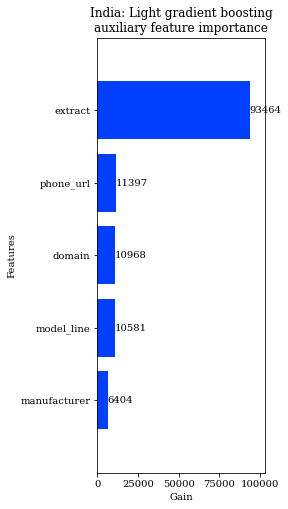

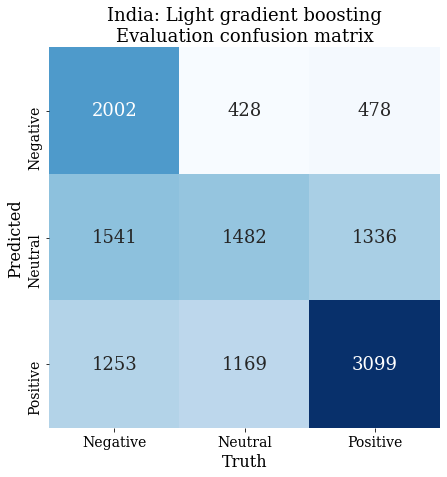

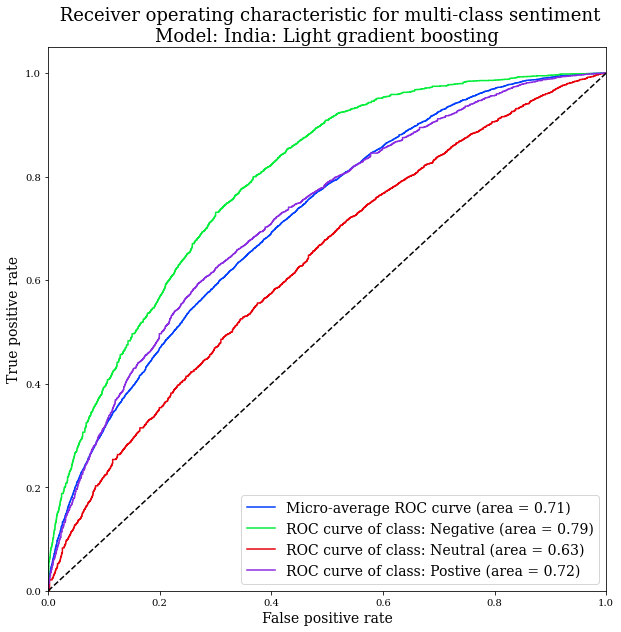

In [ ]:
i = 2
Xt,Yt, Xv, Yv, Xe, Ye = dataset_splitting(c_w_df[COUNTRY[i]], tensorflow=False, One_hot=False)
data_train = lgb.Dataset(data=Xt, label=Yt, feature_name='auto',
                        categorical_feature='auto')
data_val = lgb.Dataset(data=Xv, label=Yv, feature_name='auto',
                       categorical_feature='auto')
data_eval = lgb.Dataset(data=Xe, label=Ye)

################################################################################
bayesian_optimizer = bayesian_ensemble_optimization(function=hyper_tuning_lgb, param_domain=PARAM_DOMAIN)
################################################################################
model_lgb = optimal_lgb(X_data=Xt, Y_data=Yt, booster=LGBMClassifier, optimizer=bayesian_optimizer)
model_evaluation_total(model_clf=model_lgb, architecture = 'LGBMBoost' , paradigm = 'Light gradient boosting', booster= LGBMClassifier)

# **Model: Categorically ordered gradient boosting: Origin country-wise analysis**

In [ ]:
FIXED_PARAMS = {
          'leaf_estimation_method'  : 'Gradient',
          'iterations'              : 50,
          'boosting_type'           : 'Plain',
          'learning_rate'           : 0.05,
          'task_type'               :'GPU',
          'devices'                 : '0:1',
          'eval_metric'             : 'MultiClass',
          'verbose'                 : False, 
          'loss_function'           : 'MultiClass',
          'bootstrap_type'          : 'MVS',
          'rsm'                     : 1
           }

PARAM_DOMAIN = {
                'max_depth'           : (2, 16), 
                'bagging_temperature' : (0.2, 1),
                'subsample'           : (0.1, 1),
                # 'colsample_bylevel'   : (0.1, 1),
                'reg_lambda'          : (0.1, 10),
                }

def hyper_tuning_cgb(max_depth, bagging_temperature, reg_lambda,
                     subsample, fixed_params=FIXED_PARAMS): # colsample_bylevel,
  params = fixed_params
  params['max_depth']               = min(16, round(max_depth))
  params['bagging_temperature']     = bagging_temperature
  params['subsample']               = subsample
 #  params['colsample_bylevel']       = colsample_bylevel
  params['reg_lambda']              = reg_lambda

  cv_scores = cgb.cv(data_train, params, nfold=5)
  return 1.0*cv_scores['test-MultiClass-mean'].iloc[-1]


def model_evaluation_total(model_clf, architecture, paradigm, booster):
  m =  optimal_cgb(X_data=Xt, Y_data =Yt, booster=booster , fixed_params=FIXED_PARAMS, optimizer=bayesian_optimizer)
  NAME = f"{COUNTRY[i]}: {paradigm}"
  ARCHITECT  = architecture
  feature_importance_plotting_cgb(model=model_clf, model_name=NAME)
  gradient_boosting_model_saving(clf=model_clf, country=COUNTRY[i], model_name=NAME, architecture=ARCHITECT)
  m = gradient_boosting_model_loading(model_name=NAME, country=COUNTRY[i], architecture=ARCHITECT)
  Ye_1H = pd.get_dummies(Ye.astype('category'), prefix='Sentiment')
  model_evaluation(model=m, evaluation_features=Xe, evaluation_targets=Ye_1H, model_name=NAME, history_object=None, tensorflow=False)

def optimal_cgb(X_data, Y_data, booster, optimizer, fixed_params=FIXED_PARAMS):
  '''Function fits and returns optimal gradient booster'''
  optimal_params = optimizer.max['params']
  optimal_params['max_depth'] =  int(optimal_params['max_depth'])
  optimal_params.update(fixed_params)

  model_booster =  booster(**optimal_params).fit(X = X_data, y =Y_data, sample_weight=compute_sample_weight(class_weight='balanced',y=Y_data))
  return model_booster

### **Fitting model: British review subset**

In [ ]:
i = 0
Xt,Yt, Xv, Yv, Xe, Ye = dataset_splitting(c_w_df[COUNTRY[i]], tensorflow=False, One_hot=False)

data_train = cgb.Pool(data=Xt, label=Yt, cat_features=list(Xt.columns))
data_val = cgb.Pool(data=Xv, label=Yv, cat_features=list(Xt.columns) )
data_eval = cgb.Pool(data=Xe, label=Ye, cat_features=list(Xt.columns))

################################################################################
bayesian_optimizer = bayesian_ensemble_optimization(function=hyper_tuning_cgb, param_domain=PARAM_DOMAIN)
################################################################################
model_cgb = optimal_cgb(X_data=Xt, Y_data=Yt, booster=CatBoostClassifier, optimizer=bayesian_optimizer)
model_evaluation_total(model_clf=model_cgb, architecture = 'CatBoost' , paradigm = 'Categorically ordered gradient boosting', booster= CatBoostClassifier)

Eval set ========: 10.00%
Val set =========: 18.00%
Train set =======: 72.00%
|   iter    |  target   | baggin... | max_depth | reg_la... | subsample |
-------------------------------------------------------------------------


### **Fitting model: American review subset**

In [ ]:
i = 1
Xt,Yt, Xv, Yv, Xe, Ye = dataset_splitting(c_w_df[COUNTRY[i]], tensorflow=False, One_hot=False)

data_train = cgb.Pool(data=Xt, label=Yt, cat_features=list(Xt.columns))
data_val = cgb.Pool(data=Xv, label=Yv, cat_features=list(Xt.columns) )
data_eval = cgb.Pool(data=Xe, label=Ye, cat_features=list(Xt.columns))

################################################################################
bayesian_optimizer = bayesian_ensemble_optimization(function=hyper_tuning_cgb, param_domain=PARAM_DOMAIN)
################################################################################
model_cgb = optimal_cgb(X_data=Xt, Y_data=Yt, booster=CatBoostClassifier, optimizer=bayesian_optimizer)
model_evaluation_total(model_clf=model_cgb, architecture = 'CatBoost' , paradigm = 'Categorically ordered gradient boosting', booster= CatBoostClassifier)

### **Fitting model: Indian review subset**

In [ ]:
i = 0
Xt,Yt, Xv, Yv, Xe, Ye = dataset_splitting(c_w_df[COUNTRY[i]], tensorflow=False, One_hot=False)

data_train = cgb.Pool(data=Xt, label=Yt, cat_features=list(Xt.columns))
data_val = cgb.Pool(data=Xv, label=Yv, cat_features=list(Xt.columns) )
data_eval = cgb.Pool(data=Xe, label=Ye, cat_features=list(Xt.columns))

################################################################################
bayesian_optimizer = bayesian_ensemble_optimization(function=hyper_tuning_cgb, param_domain=PARAM_DOMAIN)
################################################################################
model_cgb = optimal_cgb(X_data=Xt, Y_data=Yt, booster=CatBoostClassifier, optimizer=bayesian_optimizer)
model_evaluation_total(model_clf=model_cgb, architecture = 'CatBoost' , paradigm = 'Categorically ordered gradient boosting', booster= CatBoostClassifier)

# **Model: Deep network: Convolving textual information and embedding categorical**

In [ ]:
Xt, Yt, Xv, Yv, Xe, Ye = dataset_splitting(df, tensorflow=True, One_hot=False)

In [ ]:
VOCAB_SIZE, OUTPUT_DIMENSION, EXTRACT_MAX_LENGTH= 10000, 64, 100
def get_model_1(max_len=EXTRACT_MAX_LENGTH, vocab_size=VOCAB_SIZE, embedding_dim=OUTPUT_DIMENSION):
  input_extract_conv = Input(shape=(max_len,), name='extract')
  input_country = Input(shape=(1,), name='country')
  input_model_line = Input(shape=(1,), name='model_line')
  input_manufacturer = Input(shape=(1,), name='manufacturer')
  input_phone = Input(shape=(1,), name='phone')
  input_domain = Input(shape=(1,), name='domain')
  ################################################################
  x_country  = Embedding(input_dim=NO_COUNTRY, output_dim=5, name='Embedding_country')(input_country)
  x_country = Reshape(input_shape=(1, 5), target_shape=(5,), name='Reshape_country')(x_country)
  x_model_line = Embedding(input_dim=NO_MODEL_LINE, output_dim=16, name='Embedding_model_line')(input_model_line)
  x_model_line = Reshape(input_shape=(1,16), target_shape=(16,), name='Reshape_model_line')(x_model_line)
  x_manufacturer = Embedding(input_dim=NO_MANUFACTURER, output_dim=10, name='Embedding_manufacturer')(input_manufacturer)
  x_manufacturer = Reshape(input_shape=(1,10), target_shape=(10,), name='Reshape_manufacturer')(x_manufacturer)
  x_phone = Embedding(input_dim=NO_PHONE, output_dim=32, name='Embedding_phone')(input_phone)
  x_phone = Reshape(input_shape=(1,32), target_shape=(32,), name='Reshape_phone')(x_phone)
  x_domain = Embedding(input_dim=NO_DOMAIN, output_dim=16, name='Embedding_domain')(input_domain)
  x_domain = Reshape(input_shape=(1,16), target_shape=(16,), name='Reshape_domain')(x_domain)
#############################################
  x_extract_conv = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,name='Embedding_extract')(input_extract_conv)
  x_extract_conv = Conv1D(filters=128, kernel_size=5, strides=1, activation='relu', name='Convolve_extract')(x_extract_conv)
  x_extract_conv = GlobalMaxPooling1D(name='Max_pooling_extract')(x_extract_conv)
  x_extract_conv = Dense(units=10, activation='relu', name='Fully_connected_extract')(x_extract_conv)
#############################################
  x_concate_input = concatenate([x_country, x_model_line, x_manufacturer, x_phone, x_domain, x_extract_conv], axis=-1)
  x = Dense(units=200, activation='relu')(x_concate_input)
  x = Dropout(rate=0.5)(x)
  x = Dense(units=100, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  outputs = Dense(units= 3, activation='softmax', name='sentiment')(x)
  inputs=[input_phone, input_country, input_domain, input_manufacturer, input_model_line, input_extract_conv]
  return Model(inputs, outputs)

m1 = get_model_1()
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

LR_scheduler_callback = LearningRateScheduler(scheduler)
m1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
m1.summary()
plot_model(m1)

### **Fitting model and evaluation**

In [ ]:
NAME='/LSTM_concate_parallel_network'
History, m1 = fitting_model(model=m1, number_of_epochs=20, name=NAME)
m1 = load_model('/content/gdrive/My Drive/Colab Notebooks/phone_user_reviews/nlp_scripts/fitted_models/LSTM_concate_parallel_network')
model_evalution(model=m1,evaluation_features=Xe, evaluation_targets=Ye, name=NAME, history_object=History)

# **Model: Deep network: Bidirectional convolving of textual information and embedding categorical**

In [ ]:
VOCAB_SIZE, OUTPUT_DIMENSION, EXTRACT_MAX_LENGTH= 10000, 64, 100

def get_model_2(max_len=EXTRACT_MAX_LENGTH, vocab_size=VOCAB_SIZE, embedding_dim=OUTPUT_DIMENSION):
  ################################################################
  input_extract_LSTM = Input(shape=(max_len,), name='extract')
  input_country = Input(shape=(1,), name='country')
  input_model_line = Input(shape=(1,), name='model_line')
  input_manufacturer = Input(shape=(1,), name='manufacturer')
  input_phone = Input(shape=(1,), name='phone')
  input_domain = Input(shape=(1,), name='domain')
  ################################################################
  x_country  = Embedding(input_dim=NO_COUNTRY, output_dim=5, name='Embedding_country')(input_country)
  x_country = Reshape(input_shape=(1, 5), target_shape=(5,), name='Reshape_country')(x_country)

  x_model_line = Embedding(input_dim=NO_MODEL_LINE, output_dim=16, name='Embedding_model_line')(input_model_line)
  x_model_line = Reshape(input_shape=(1,16), target_shape=(16,), name='Reshape_model_line')(x_model_line)

  x_manufacturer = Embedding(input_dim=NO_MANUFACTURER, output_dim=10, name='Embedding_manufacturer')(input_manufacturer)
  x_manufacturer = Reshape(input_shape=(1,10), target_shape=(10,), name='Reshape_manufacturer')(x_manufacturer)

  x_phone = Embedding(input_dim= NO_PHONE, output_dim=32, name='Embedding_phone')(input_phone)
  x_phone = Reshape(input_shape=(1,32), target_shape=(32,), name='Reshape_phone')(x_phone)

  x_domain = Embedding(input_dim=NO_DOMAIN, output_dim=16, name='Embedding_domain')(input_domain)
  x_domain = Reshape(input_shape=(1,16), target_shape=(16,), name='Reshape_domain')(x_domain)
  #############################################
  x_extract_LSTM = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, name='Embedding_extract')(input_extract_LSTM)
  # back and forward LSTM pass
  ##########################

  x_extract_LSTM_forwards = LSTM(units=32, return_sequences=True, name='Forwards_LSTM_pass')(x_extract_LSTM)
  x_extract_LSTM_backwards = LSTM(units=32, return_sequences=True, go_backwards=True, name='Backwards_LSTM_pass')(x_extract_LSTM)
  ##########################
  x_extract_LSTM = Average()([x_extract_LSTM_forwards, x_extract_LSTM_backwards])
  x_extract_LSTM = TimeDistributed(Dense(units=1, activation='elu'))(x_extract_LSTM)  
  x_extract_LSTM = Reshape(input_shape=(1,100), target_shape=(100,))(x_extract_LSTM)
  #############################################
  x_concate_input = concatenate([x_country, x_model_line, x_manufacturer, x_phone, x_domain, x_extract_LSTM], axis=-1)
  x = Dense(units=200, activation='relu')(x_concate_input)
  x = Dropout(rate=0.5)(x)
  x = Dense(units=100, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  outputs = Dense(units= 3, activation='sigmoid', name='sentiment')(x)
  inputs = [input_phone, input_country, input_domain, input_manufacturer, input_model_line, input_extract_LSTM]
  return Model(inputs, outputs)

m2 = get_model_2()
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

m2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'], )
m2.summary()
plot_model(m2)

### **Fitting model and evaluation**

Classification report
              precision    recall  f1-score   support

    Negative       0.77      0.74      0.76     10935
     Neutral       0.60      0.55      0.58     17127
    Positive       0.77      0.83      0.80     26481

    accuracy                           0.72     54543
   macro avg       0.72      0.71      0.71     54543
weighted avg       0.72      0.72      0.72     54543
:



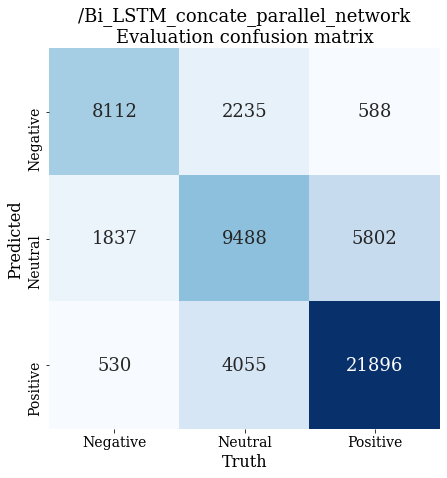

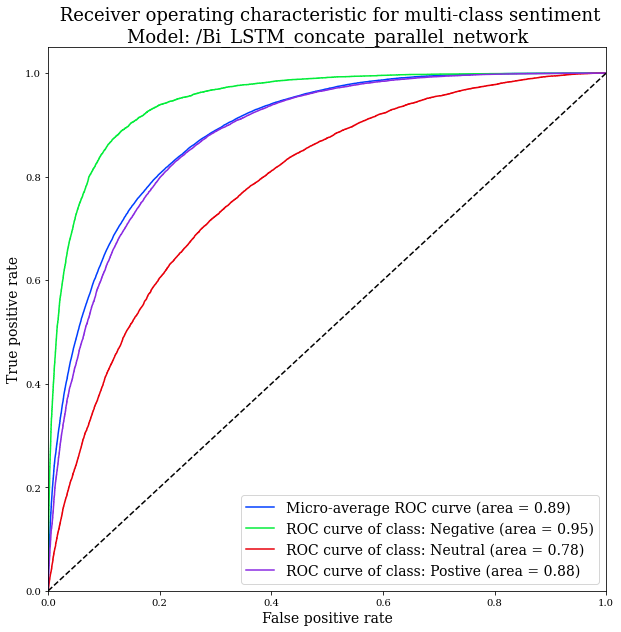

In [ ]:
NAME='/Bi_LSTM_concate_parallel_network'
History, m2 = fitting_model(model=m2, number_of_epochs=20, name=NAME)
m2 = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/phone_user_reviews/nlp_scripts/fitted_models/Bi_LSTM_concate_parallel_network')
model_evaluation(model=m2, evaluation_features=Xe, evaluation_targets=Ye, model_name=NAME, history_object=History)

# **Model: Deep network: Birectional convolving with attention mechanism on textual information and embedding categorical**

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
extract (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
Embedding_extract (Embedding)   (None, 100, 64)      640000      extract[0][0]                    
__________________________________________________________________________________________________
lstm_22 (LSTM)                  (None, 100, 64)      33024       Embedding_extract[0][0]          
__________________________________________________________________________________________________
lstm_23 (LSTM)                  (None, 100, 64)      33024       Embedding_extract[0][0]          
_______________________________________________________________________________________

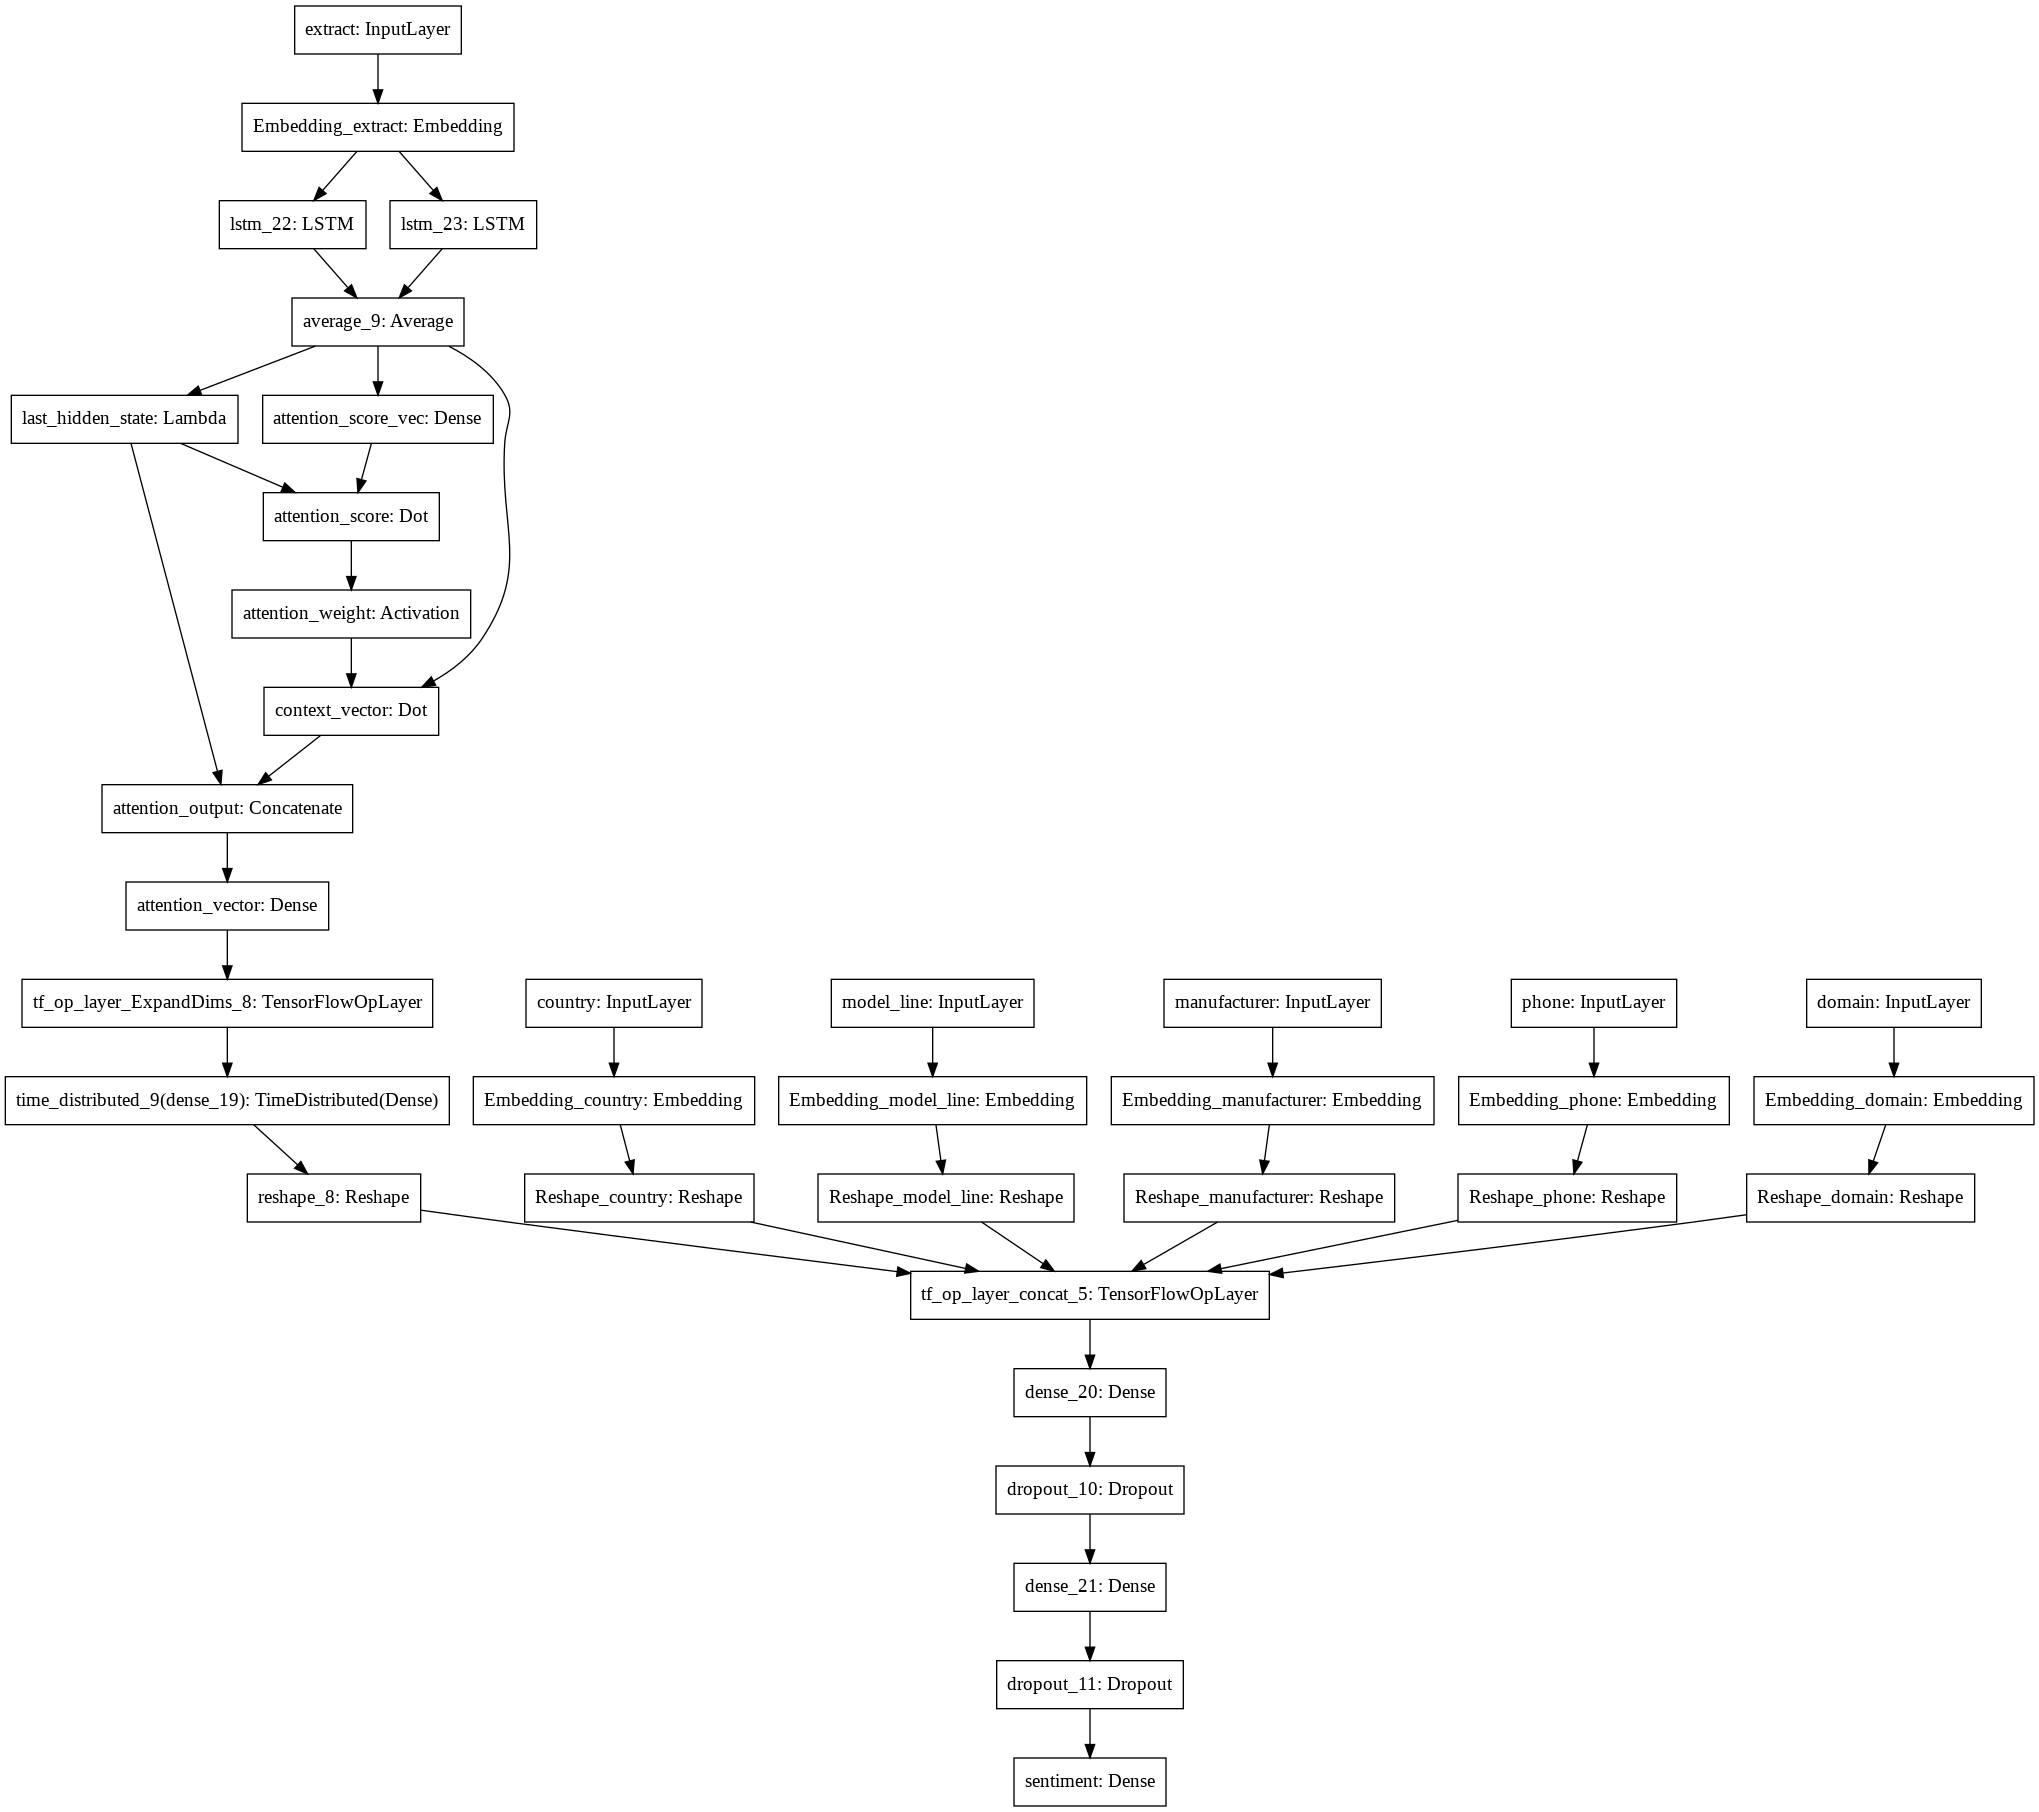

In [ ]:
VOCAB_SIZE, OUTPUT_DIMENSION, EXTRACT_MAX_LENGTH= 10000, 64, 100 
def get_model_3(max_len=EXTRACT_MAX_LENGTH, vocab_size=VOCAB_SIZE, embedding_dim=OUTPUT_DIMENSION):
################################################################
  input_extract_LSTM_Attention = Input(shape=(max_len,), name='extract')
  input_country = Input(shape=(1,), name='country')
  input_model_line = Input(shape=(1,), name='model_line')
  input_manufacturer = Input(shape=(1,), name='manufacturer')
  input_phone = Input(shape=(1,), name='phone')
  input_domain = Input(shape=(1,), name='domain')
##################################################################################################
  x_country  = Embedding(input_dim=NO_COUNTRY, output_dim=5, name='Embedding_country')(input_country)
  x_country = Reshape(input_shape=(1, 5), target_shape=(5,), name='Reshape_country')(x_country)
  x_model_line = Embedding(input_dim=NO_MODEL_LINE, output_dim=16, name='Embedding_model_line')(input_model_line)
  x_model_line = Reshape(input_shape=(1,16), target_shape=(16,), name='Reshape_model_line')(x_model_line)
  x_manufacturer = Embedding(input_dim=NO_MANUFACTURER, output_dim=10, name='Embedding_manufacturer')(input_manufacturer)
  x_manufacturer = Reshape(input_shape=(1,10), target_shape=(10,), name='Reshape_manufacturer')(x_manufacturer)
  x_phone = Embedding(input_dim= NO_PHONE, output_dim=32, name='Embedding_phone')(input_phone)
  x_phone = Reshape(input_shape=(1,32), target_shape=(32,), name='Reshape_phone')(x_phone)
  x_domain = Embedding(input_dim=NO_DOMAIN, output_dim=16, name='Embedding_domain')(input_domain)
  x_domain = Reshape(input_shape=(1,16), target_shape=(16,), name='Reshape_domain')(x_domain)
###################################################################################################
  x_extract_LSTM_Attention = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,name='Embedding_extract')(input_extract_LSTM_Attention)

  x_extract_LSTM_forwards = LSTM(units=64, return_sequences=True)(x_extract_LSTM_Attention)
  x_extract_LSTM_backwards = LSTM(units=64, return_sequences=True, go_backwards=True)(x_extract_LSTM_Attention)

  x_extract_LSTM_Attention = Average()([x_extract_LSTM_forwards, x_extract_LSTM_backwards])
  x_extract_LSTM_Attention = Attention(name='Forward_pass_LSTM_Attention')(x_extract_LSTM_Attention)  

  x_extract_LSTM_Attention = tf.expand_dims(x_extract_LSTM_Attention, axis=1)

  x_extract_LSTM_Attention = TimeDistributed(Dense(units=100, activation='elu'))(x_extract_LSTM_Attention)  
  x_extract_LSTM_Attention = Reshape(input_shape=(1,100), target_shape=(100,))(x_extract_LSTM_Attention)

####################################################################################################
  x_concate_input = concatenate([x_country, x_model_line, x_manufacturer, x_phone, x_domain, x_extract_LSTM_Attention], axis=-1)
  x = Dense(units=200, activation='relu')(x_concate_input)
  x = Dropout(rate=0.5)(x)
  x = Dense(units=100, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  outputs = Dense(units= 3, activation='sigmoid', name='sentiment')(x)
  inputs=[input_phone, input_country, input_domain,input_manufacturer, input_model_line, input_extract_LSTM_Attention]
  return Model(inputs, outputs)

m2 = get_model_3()
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
LR_scheduler_callback = LearningRateScheduler(scheduler)
m3 = get_model_3()
m3.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
           loss='categorical_crossentropy',
           metrics=['accuracy'])
m3.summary()
plot_model(m3)

### **Fitting model and evaluation**

Classification report
              precision    recall  f1-score   support

    Negative       0.80      0.73      0.77     11000
     Neutral       0.60      0.56      0.58     17099
    Positive       0.77      0.83      0.80     26444

    accuracy                           0.73     54543
   macro avg       0.73      0.71      0.72     54543
weighted avg       0.72      0.73      0.72     54543
:



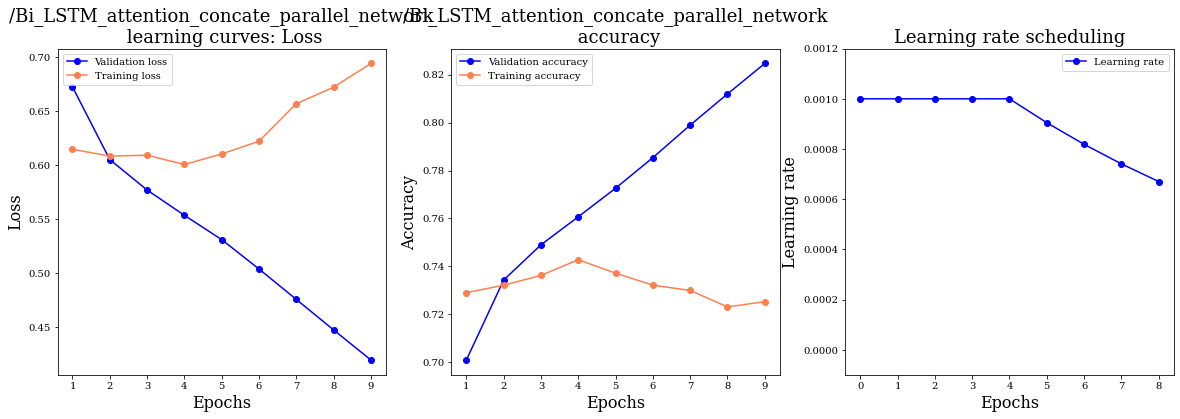

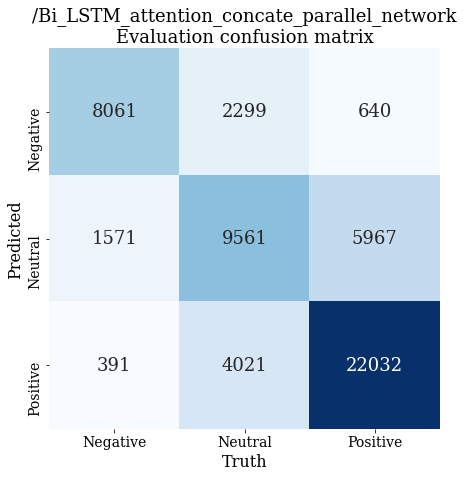

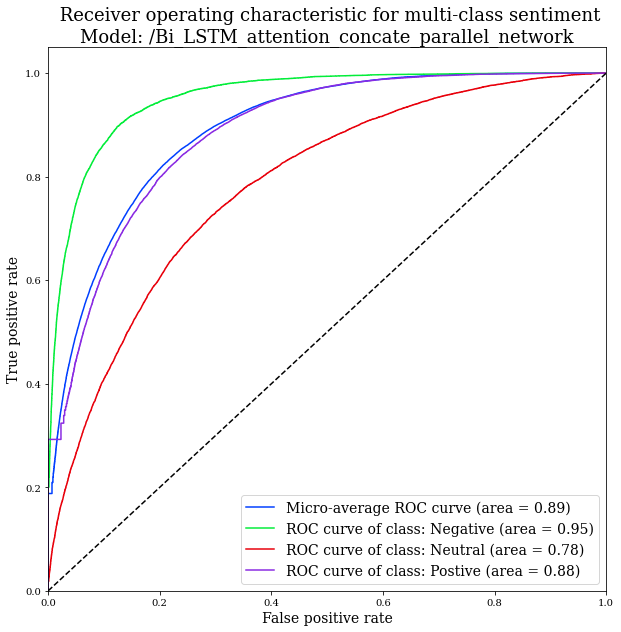

In [ ]:
NAME='/Bi_LSTM_attention_concate_parallel_network'
History, m3 = fitting_model(model=m3, number_of_epochs=20, name=NAME)
m3 = load_model('/content/gdrive/My Drive/Colab Notebooks/phone_user_reviews/nlp_scripts/fitted_models/Bi_LSTM_attention_concate_parallel_network')
model_evaluation(model=m3, evaluation_features=Xe, evaluation_targets=Ye, model_name=NAME, history_object=History)